In [1]:
import deepxde as dde
import torch
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda")

Using backend: pytorch



In [2]:
Re = 20
nu = 1 / Re
l = 1 / (2 * nu) - np.sqrt(1 / (4 * nu ** 2) + 4 * np.pi ** 2)

In [3]:
def pde(x, u):
    u_vel, v_vel, p = u[:, 0:1], u[:, 1:2], u[:, 2:]
    u_vel_x = dde.grad.jacobian(u, x, i=0, j=0)
    u_vel_y = dde.grad.jacobian(u, x, i=0, j=1)
    u_vel_xx = dde.grad.hessian(u, x, component=0, i=0, j=0)
    u_vel_yy = dde.grad.hessian(u, x, component=0, i=1, j=1)

    v_vel_x = dde.grad.jacobian(u, x, i=1, j=0)
    v_vel_y = dde.grad.jacobian(u, x, i=1, j=1)
    v_vel_xx = dde.grad.hessian(u, x, component=1, i=0, j=0)
    v_vel_yy = dde.grad.hessian(u, x, component=1, i=1, j=1)

    p_x = dde.grad.jacobian(u, x, i=2, j=0)
    p_y = dde.grad.jacobian(u, x, i=2, j=1)

    momentum_x = (
        u_vel * u_vel_x + v_vel * u_vel_y + p_x - 1 / Re * (u_vel_xx + u_vel_yy)
    )
    momentum_y = (
        u_vel * v_vel_x + v_vel * v_vel_y + p_y - 1 / Re * (v_vel_xx + v_vel_yy)
    )
    continuity = u_vel_x + v_vel_y

    return [momentum_x, momentum_y, continuity]

In [4]:
def u_func(x):
    return 1 - np.exp(l * x[:, 0:1]) * np.cos(2 * np.pi * x[:, 1:2])


def v_func(x):
    return l / (2 * np.pi) * np.exp(l * x[:, 0:1]) * np.sin(2 * np.pi * x[:, 1:2])


def p_func(x):
    return 1 / 2 * (1 - np.exp(2 * l * x[:, 0:1]))

In [5]:
def boundary_outflow(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)

In [6]:
spatial_domain = dde.geometry.Rectangle(xmin=[-0.5, -0.5], xmax=[1, 1.5])

boundary_condition_u = dde.icbc.DirichletBC(
    spatial_domain, u_func, lambda _, on_boundary: on_boundary, component=0
)
boundary_condition_v = dde.icbc.DirichletBC(
    spatial_domain, v_func, lambda _, on_boundary: on_boundary, component=1
)
boundary_condition_right_p = dde.icbc.DirichletBC(
    spatial_domain, p_func, boundary_outflow, component=2
)

data = dde.data.PDE(
    spatial_domain,
    pde,
    [boundary_condition_u, boundary_condition_v, boundary_condition_right_p],
    num_domain=2601,
    num_boundary=400,
    num_test=100000,
)

In [7]:
net = dde.nn.FNN([2] + 4 * [50] + [3], "tanh", "Glorot normal")

In [8]:
model = dde.Model(data, net)

In [23]:
# restore
model.compile("adam", lr=1e-3)
model.restore(save_path="model/model.ckpt-19000.pt", verbose=1)

Compiling model...
'compile' took 0.000338 s

Restoring model from model/model.ckpt-19000.pt ...



In [9]:
# train with adam
model.compile("adam", lr=1e-3)
checkpointer = dde.callbacks.ModelCheckpoint("model/model.ckpt",
                                             verbose=1,
                                             save_better_only=True)
losshistory, train_state = model.train(iterations=30000, callbacks=[checkpointer])

Compiling model...
'compile' took 0.000225 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.38e-01, 2.38e-02, 8.75e-01, 4.03e+00, 2.07e-01, 1.05e-01]    [1.42e-01, 2.47e-02, 8.95e-01, 4.03e+00, 2.07e-01, 1.05e-01]    []  
Epoch 1: train loss improved from inf to 5.38e+00, saving model to model/model.ckpt-1.pt ...



In [ ]:
dde.utils.external.save_loss_history(loss_history=losshistory, fname="losses/loss")
dde.utils.external.plot_loss_history(loss_history=losshistory)

In [29]:
X = spatial_domain.uniform_points(100000)
output = model.predict(X)
u_pred = output[:, 0]
v_pred = output[:, 1]
p_pred = output[:, 2]

u_exact = u_func(X).reshape(-1)
v_exact = v_func(X).reshape(-1)
p_exact = p_func(X).reshape(-1)

f = model.predict(X, operator=pde)

l2_difference_u = dde.metrics.l2_relative_error(u_exact, u_pred)
l2_difference_v = dde.metrics.l2_relative_error(v_exact, v_pred)
l2_difference_p = dde.metrics.l2_relative_error(p_exact, p_pred)
residual = np.mean(np.absolute(f))

print("Mean residual:", residual)
print("L2 relative error in u:", l2_difference_u)
print("L2 relative error in v:", l2_difference_v)
print("L2 relative error in p:", l2_difference_p)

Mean residual: 0.008069737
L2 relative error in u: 0.009478379
L2 relative error in v: 0.025552198
L2 relative error in p: 0.008889952


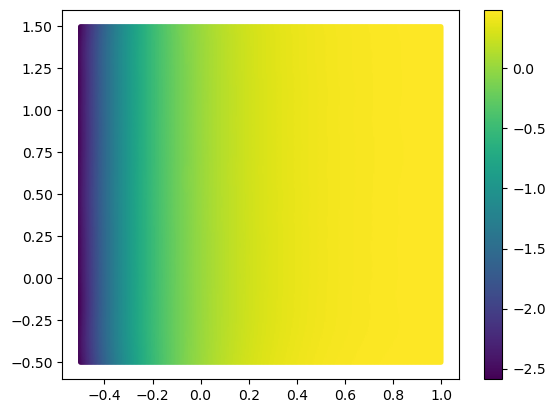

In [32]:
plt.scatter(X[:, 0], X[:, 1], c=p_pred, s=5)
plt.colorbar()
plt.show()

In [33]:
plt.plot(losshistory)

NameError: name 'losshistory' is not defined

In [35]:
ckpt = torch.load("model/model.ckpt-19000.pt")

In [38]:
ckpt.keys()

dict_keys(['model_state_dict', 'optimizer_state_dict'])